# **NLP Project**

## **Milestone 1**


## **Imports & Downloads**

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense, Embedding, TextVectorization
from keras.utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
!pip install textblob
!pip install pyspellchecker
!pip install fuzzywuzzy
!pip install python-Levenshtein
nltk.download('popular');


## **Import Dataset**

In [3]:
# Importing the spotify million song dataset
df = pd.read_csv("/content/drive/MyDrive/spotify_million_dataset.csv")

## **Data Cleaning**

In [4]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

df['clean_song'] = df['text'].apply(remove_punctuation)
df['clean_song'] = df['clean_song'].apply(remove_stopwords)
df['clean_song'] = df['clean_song'].apply(lemmatize_text)

df['song_len'] = df['text'].str.len()
df['clean_song_len'] = df['clean_song'].str.len()

## **Exploratory Analysis**

In [22]:
""" Get top 20 artists  """
artist_df = (
    df['artist'].value_counts()
    .head(10)
    .rename_axis('values')
    .reset_index(name = 'counts')
)

avg_len_df = df.groupby('artist')['clean_song_len'].aggregate('mean').head(20)

## **Data Visualization**

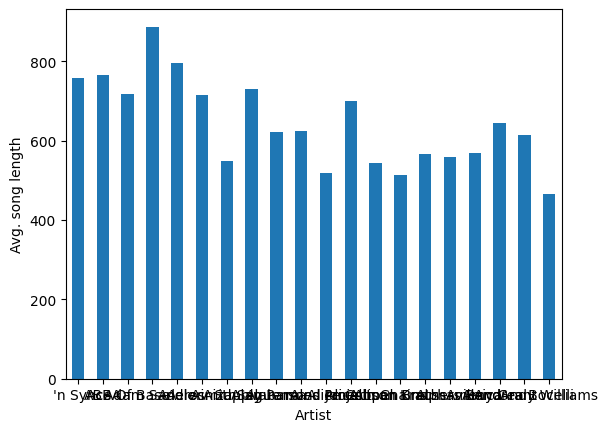

In [23]:
avg_len_df.plot(kind='bar')
plt.xlabel('Artist')
plt.ylabel('Avg. song length')
plt.xticks(rotation=0)
plt.show()

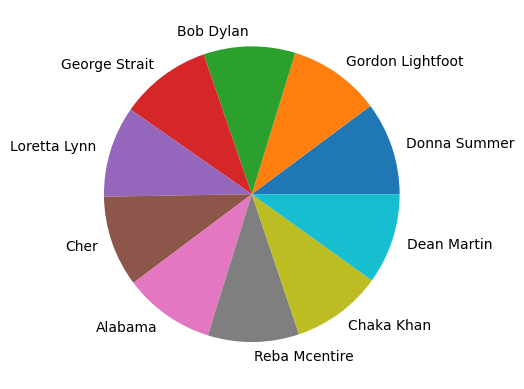

In [24]:
plt.pie(artist_df['counts'], labels=artist_df['values'])
plt.show()

# **Milestone 2**

## **Preprocess Data**

In [8]:
sample_df = df[:500] #Work with only 500 rows due to memory usage

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sample_df['clean_song'])
total_words = len(tokenizer.word_index) + 1

In [9]:
input_sequences = []
for line in sample_df['clean_song']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [10]:
X, y = input_sequences[:,:-1],input_sequences[:,-1]
y = to_categorical(y, num_classes=total_words)

## **The Model**

In [13]:
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(LSTM(64))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

steps_per_epoch = len(X) // 32  # Calculate steps per epoch

model.fit(X, y, epochs=20, batch_size=32, steps_per_epoch=steps_per_epoch, verbose=1)


Epoch 1/20
1788/1788 [==============================] - 451s 250ms/step - loss: 7.1491 - accuracy: 0.0210
Epoch 2/20
1788/1788 [==============================] - 446s 250ms/step - loss: 6.7263 - accuracy: 0.0315
Epoch 3/20
1788/1788 [==============================] - 447s 250ms/step - loss: 6.4072 - accuracy: 0.0452
Epoch 4/20
1788/1788 [==============================] - 451s 252ms/step - loss: 6.0803 - accuracy: 0.0644
Epoch 5/20
1788/1788 [==============================] - 447s 250ms/step - loss: 5.7553 - accuracy: 0.0894
Epoch 6/20
1788/1788 [==============================] - 449s 251ms/step - loss: 5.4459 - accuracy: 0.1177
Epoch 7/20
1788/1788 [==============================] - 449s 251ms/step - loss: 5.1550 - accuracy: 0.1473
Epoch 8/20
1788/1788 [==============================] - 448s 251ms/step - loss: 4.8843 - accuracy: 0.1753
Epoch 9/20
1788/1788 [==============================] - 447s 250ms/step - loss: 4.6333 - accuracy: 0.2032
Epoch 10/20
1788/1788 [=======================

## **Generate Output Text**

In [21]:
# Function to generate text
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]
        predicted_index = np.argmax(predicted_probs)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

seed_text = "input seed text here"
generated_text = generate_text(seed_text, 20, model, max_sequence_len)
print(generated_text)

input seed text here free face tells time come back come back chorus chorus chorus chorus goodbye goodbye goodbye goodbye love love love love
